In [31]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import matplotlib.animation as animation
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [32]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = datasets.MNIST('data', train=True, download=True, transform= transform)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

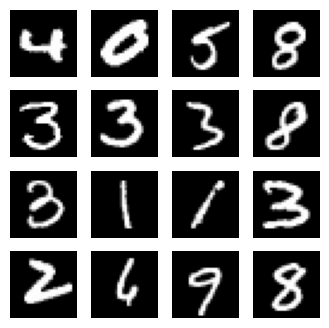

In [33]:
def show_batch(images):
    fig, ax = plt.subplots(4, 4, figsize=(4, 4))
    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i].detach().cpu().numpy().squeeze(), cmap='gray')
        axi.axis('off')

images, _ = next(iter(train_loader))
show_batch(images)

real_label = 1
fake_label = 0

In [34]:
class Descriminator(nn.Module):

    def __init__(self) -> None:
        super().__init__()
        num_features = 64
        
        self.layers = nn.Sequential(
            # 1 x 28 x 28
            nn.Conv2d(1, num_features, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),

            # 4 x 14 x 14
            nn.Conv2d(num_features, num_features * 2, 4, 2, 1),
            nn.BatchNorm2d(num_features * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # 16 x 7 x 7
            nn.Conv2d(num_features * 2, num_features * 4, 3, 2, 1),
            nn.BatchNorm2d(num_features * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # 32 x 4 x 4
            nn.Conv2d(num_features * 4, 1, 4, 1, 0),
            nn.Flatten(),
            nn.Linear(1, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

In [35]:
lsize = 20
fixed_noise = torch.randn(2, lsize, 1, 1)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        num_features = 64
        self.layers = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( lsize, num_features * 8, 4, 1, 0, bias= False),
            nn.BatchNorm2d(num_features * 8),
            nn.ReLU(True),

            # 4 x 4
            nn.ConvTranspose2d( num_features * 8, num_features * 4, 4, 2, 1, bias= False),
            nn.BatchNorm2d(num_features * 4),
            nn.ReLU(True),

            # 16 x 8 x 8
            nn.ConvTranspose2d( num_features * 4, num_features * 2, 4, 2, 1, bias= False),
            nn.BatchNorm2d(num_features * 2),
            nn.ReLU(True),

            # 4 x 16 x 16
            nn.ConvTranspose2d( num_features * 2, 1, 4, 2, 3, bias= False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.layers(x)

In [36]:
netD = Descriminator().to(device)
netG = Generator().to(device)

lr = 0.0002
beta1 = 0.5
nz = 20

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(20, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [37]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [38]:
img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 10

def train(num_epochs):
    fixed_noise = torch.randn((20, lsize, 1, 1), device= device)

    for epoch in range(num_epochs):
        for i, data in enumerate(train_loader):
            real = data[0].to(device)
            batch_size = real.size(0)
            label = torch.full((batch_size,), real_label, device= device, dtype= torch.float)

            netD.zero_grad()

            real_pred = netD(real).view(-1)
            real_loss = criterion(real_pred, label)
            real_loss.backward()

            noise = torch.randn(batch_size, lsize, 1, 1, device= device)

            fake = netG(noise)
            fake_pred = netD(fake.detach()).view(-1)
            label.fill_(fake_label)
            fake_loss = criterion(fake_pred, label)
            fake_loss.backward()

            optimizerD.step()

            netG.zero_grad()
            label.fill_(real_label)

            gen_output = netD(fake).view(-1)
            gen_loss = criterion(gen_output, label)
            gen_loss.backward()

            optimizerG.step()

        fake = netG(fixed_noise)
        img_list.append(vutils.make_grid(fake.detach().cpu(), padding=2, normalize=True))
        print(f"Epoch: {epoch + 1}/{num_epochs}")

train(num_epochs)
    

Epoch: 1/10
Epoch: 2/10
Epoch: 3/10
Epoch: 4/10
Epoch: 5/10
Epoch: 6/10
Epoch: 7/10
Epoch: 8/10
Epoch: 9/10
Epoch: 10/10


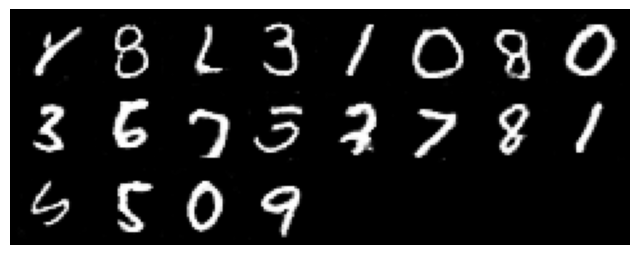

In [39]:
from IPython.display import HTML

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

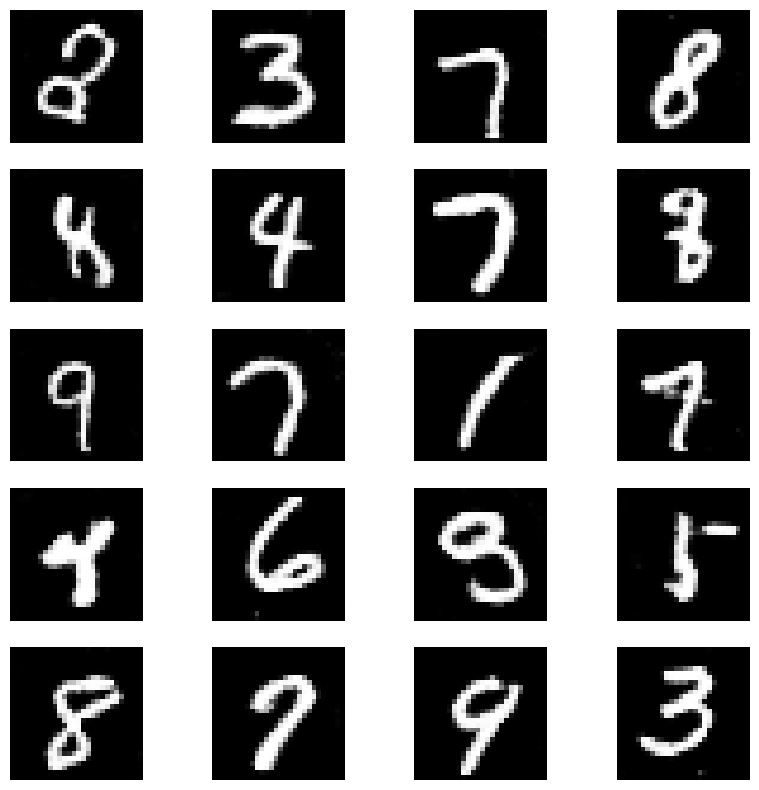

In [42]:
output = netG(fixed_noise)
output = output.detach().cpu().numpy()
output = np.transpose(output, (0, 2, 3, 1))
output = (output + 1) / 2
output = output.reshape(20, 28, 28)
plt.figure(figsize=(10, 10))
for i in range(20):
    plt.subplot(5, 4, i + 1)
    plt.imshow(output[i], cmap='gray')
    plt.axis('off')
plt.show()